<a href="https://colab.research.google.com/github/SvetlanaErmakova/Analytics-and-statistics/blob/main/advertisement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Посчитаем продуктовые метрики и исследуем распределения в датасете по рекламным кампаниям:
1. Загрузим данные и проверим число наблюдений и столбцов, типы данных, начиличе пропущенных значений, какие уникальные значения встречаются
2. Построим график распределения числа показов (Impressions) для каждой рекламы, прологарифмировав значения
3. Создадим новую колонку с CTR. Посмотрим на описательные статистики и распредление
4. Проанализируем CTR с разбивкой по рекламным кампаниям
5. Посчитаем стоимость за клик пользователя по объявлению (CPC). Изучим полученные значения, используя меры центральной тенденции и меры изменчивости
6. Визуализируем CPC с разбивкой по полу
пользователей, которым были показаны объявления
7. Посчитаем конверсию из клика в покупку

1.Загрузим данные и проверим число наблюдений и столбцов, типы данных, начиличе пропущенных значений, какие уникальные значения встречаются

In [41]:
import numpy as np
import pandas as pd
from scipy.stats import iqr #межквартильный размах
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize': (12, 6)}, style = "whitegrid")

In [42]:
conv = pd.read_csv('conversion.csv')
conv.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [43]:
conv.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

In [44]:
conv.isna().sum()

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

In [45]:
conv.xyz_campaign_id.unique()

array([ 916,  936, 1178])

In [46]:
conv.xyz_campaign_id.nunique()

3

Обратим внимание на тип переменных age, interest:

interest - в описании данных было сказано, что это код КАТЕГОРИИ, те несмотря на то что хочется назвать ее дискретной, она номинативная

age - ранговая

In [47]:
conv.age.unique()

array(['30-34', '35-39', '40-44', '45-49'], dtype=object)

2. Построим график распределения числа показов (Impressions) для каждой рекламы, прологарифмировав значения

<Axes: xlabel='Impressions', ylabel='Count'>

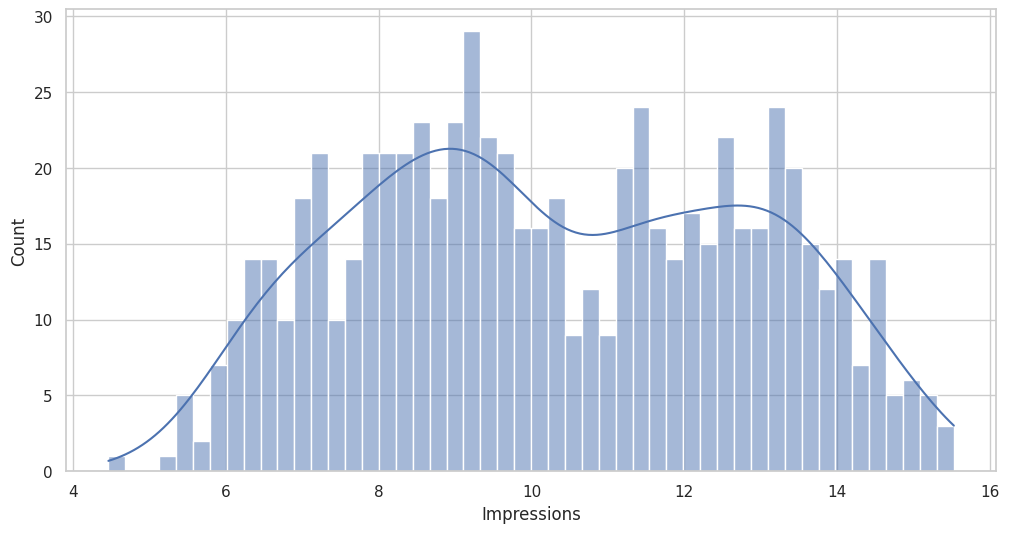

In [48]:
sns.histplot(np.log(conv.groupby('fb_campaign_id').Impressions.sum()), kde = True, bins = 50)

In [49]:
conv_grouped = conv.groupby(['xyz_campaign_id', 'fb_campaign_id'], as_index = False).Impressions.sum()
conv_grouped["Impressions"] = np.log(conv_grouped["Impressions"])
conv_grouped["xyz_campaign_id"] = conv_grouped["xyz_campaign_id"].astype("str")
conv_grouped
conv.xyz_campaign_id.unique()

array([ 916,  936, 1178])

<Axes: xlabel='Impressions', ylabel='Count'>

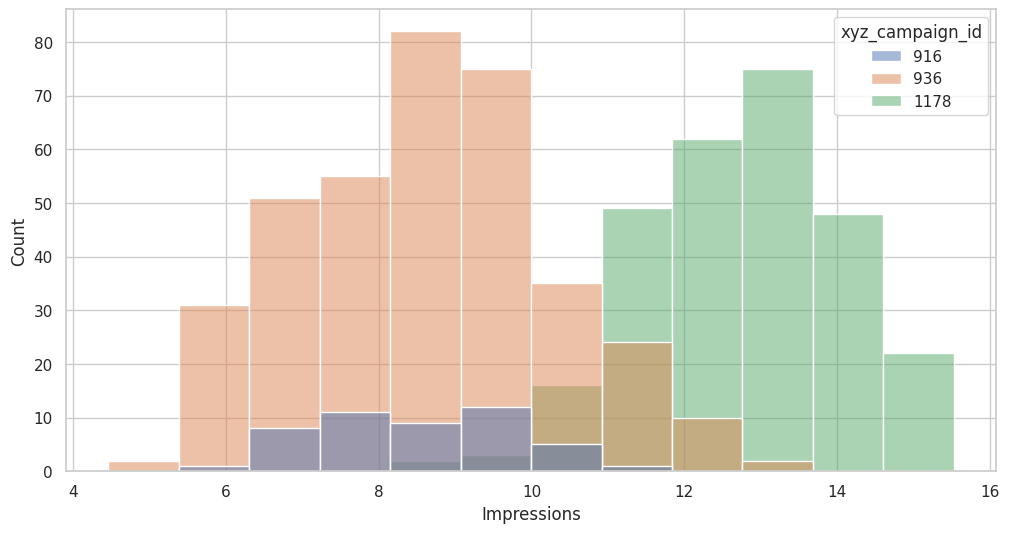

In [50]:
sns.histplot(data = conv_grouped, x = "Impressions", hue = "xyz_campaign_id")

Кластеризация - поиск подгрупп в данных с помощью машинного обучения

In [51]:
from sklearn.mixture import GaussianMixture
dat = np.log(conv.groupby('fb_campaign_id').Impressions.sum()).values.reshape(-1, 1) #так методы sklearn принимают данные
mix = GaussianMixture(n_components = 2).fit(dat) # обучаем модель на dat, ищем 2 класса
labels = mix.predict(dat) #предсказываем что к каким группам относится


<ipython-input-52-6857282fe983>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat[labels == 0], kde = False, bins = 50)
<ipython-input-52-6857282fe983>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat[labels == 1], kde = False, bins = 50)


<Axes: >

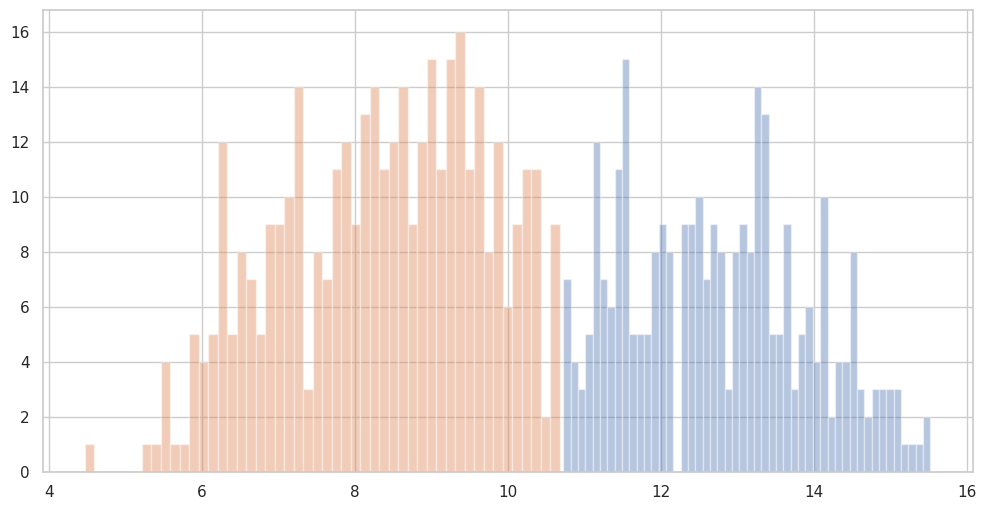

In [52]:
sns.distplot(dat[labels == 0], kde = False, bins = 50)
sns.distplot(dat[labels == 1], kde = False, bins = 50)

3. Создадим новую колонку с CTR. Посмотрим на описательные статистики и распредление
4. Проанализируем CTR с разбивкой по рекламным кампаниям

In [53]:
conv['ctr'] = conv.Clicks/conv.Impressions
conv.ctr.describe()
conv.set_index("ad_id").ctr.idxmax() #индекс который соотвт-й максимал ctr(в кач-ве индекса установили id рекламы)

738637

5. Посчитаем стоимость за клик пользователя по объявлению (CPC). Изучим полученные значения, используя меры центральной тенденции и меры изменчивости

<Axes: xlabel='ctr', ylabel='Count'>

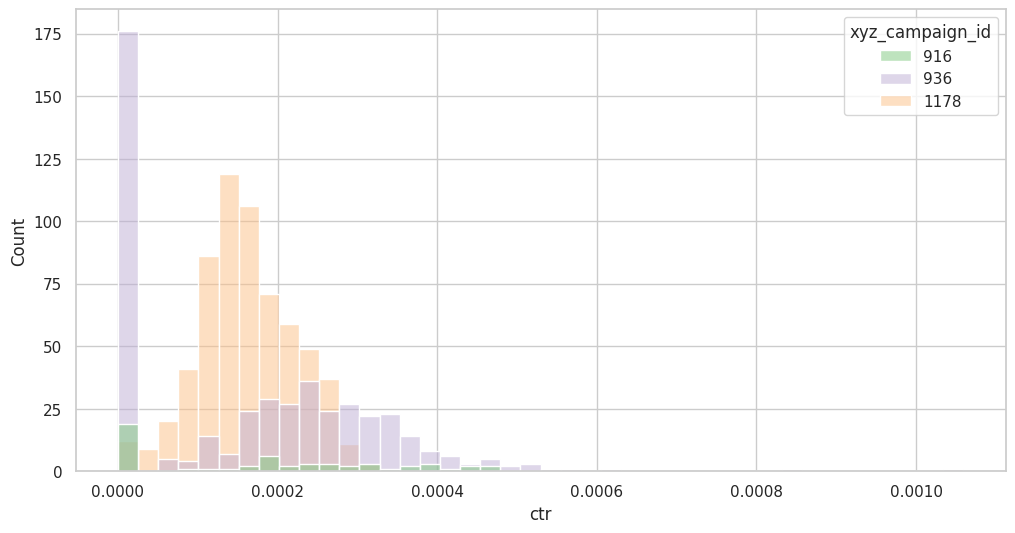

In [54]:
sns.histplot(data = conv, x = 'ctr', hue = 'xyz_campaign_id', palette = 'Accent')


<Axes: xlabel='ctr', ylabel='Count'>

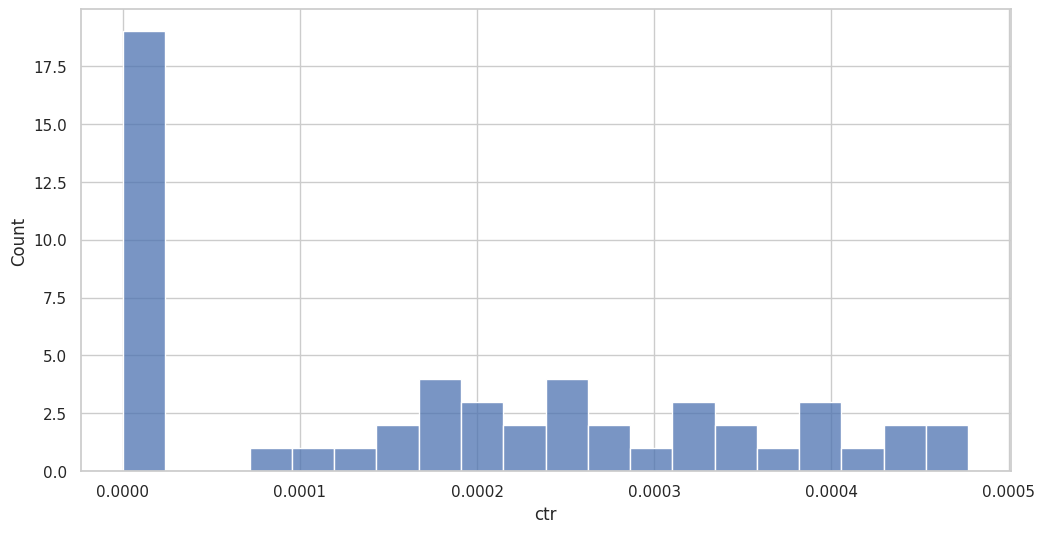

In [55]:
sns.histplot(data = conv, x = conv.query("xyz_campaign_id==916").ctr, bins = 20)

6. Визуализируем CPC с разбивкой по полу пользователей, которым были показаны объявления

In [56]:
conv['cpc'] = conv.Spent/conv.Clicks
conv.cpc.describe()


count    936.000000
mean       1.499347
std        0.232879
min        0.180000
25%        1.390000
50%        1.498273
75%        1.644364
max        2.212000
Name: cpc, dtype: float64

In [57]:
round(iqr(conv.cpc, nan_policy = 'omit'), 2) #nan_policy = 'omit'- чтобы пропустить значения путсые

0.25

<Axes: xlabel='cpc', ylabel='Count'>

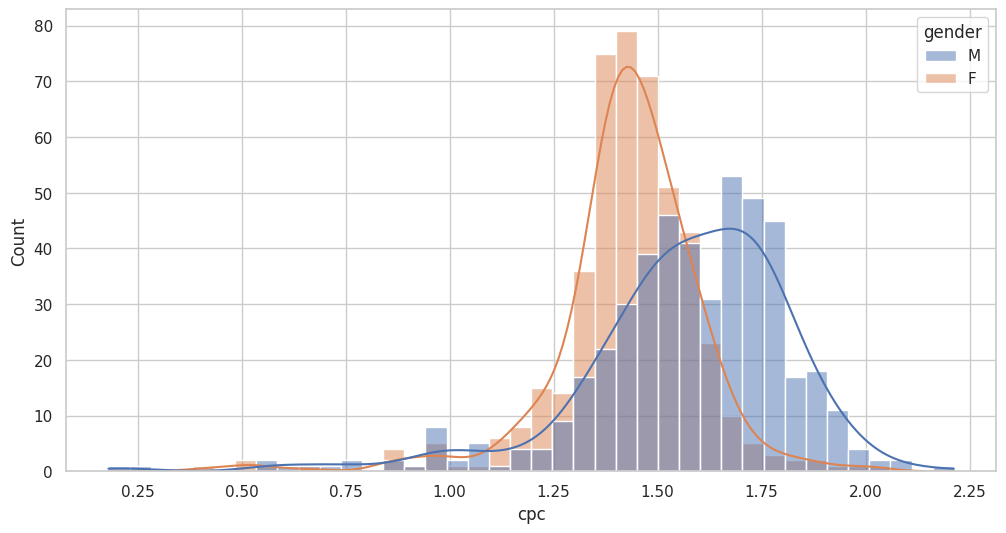

In [58]:
sns.histplot(data = conv, x = "cpc", hue = "gender", kde = True)

7. Посчитаем конверсию из клика в покупку, посчитаем конверсию для объявления 1121814

In [59]:
conv['conv_rate'] = (conv.Approved_Conversion/conv.Clicks).mul(100)
conv.query("ad_id == 1121814").conv_rate.round(2)

860    3.09
Name: conv_rate, dtype: float64